In [ ]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID";
 
# The GPU id to use, usually either "0" , "1", "2" or "3";
os.environ["CUDA_VISIBLE_DEVICES"]="0";  

In [2]:
%%capture
import warnings
warnings.simplefilter('ignore',  DeprecationWarning)
import sys

import pickle
import glob
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from keras.models import Model, load_model
from keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import log_loss
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

#include the directory with custom functions
sys.path.insert(1, '../custom_functions')
from train_functions import *
from test_functions import *

In [3]:
from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf
print(tf.__version__)

1.14.0


In [4]:
#The dir containing the model's (*.hdf5 files)
MODEL_DIR = '../../models/cv_prod_test/'

#Dirs with test dataset
TEST_IMAGES_DIR = '../../datasets/dataset_mixed/test'
TEST_DATAFRAME_PATH = os.path.join(TEST_IMAGES_DIR, "df_Forgetful_Fabio.csv")

#Dirs with train dataset
TRAIN_DATAFRAME_DIR = os.path.join(MODEL_DIR, 'temp_dataframes')
TRAIN_IMAGES_DIR = '../../datasets/dataset_mixed/train'

#Dir for saving images obtained in testing (like learning curves)
IMAGES_DIR = os.path.join(MODEL_DIR, 'images')

#Path to the config file (usually in the model dir)
CONFIG_PATH = os.path.join(MODEL_DIR, "model_config.json") 

BATCH_SIZE = 32

#IMAGE DPI for saveing plots
IMG_DPI=600


In [5]:
# Importing congig and normalization mode for generators
if not os.path.exists(IMAGES_DIR):
    os.mkdir(IMAGES_DIR)

with open(CONFIG_PATH , "r") as read_file:
    config_dict = json.load(read_file)

training_is_finished = config_dict['training_is_finished']
print('training_is_finished: ', training_is_finished)

with open(os.path.join(MODEL_DIR, 'train_history/history.json')) as file:
    history = json.load(file)
model_filenames = list(filter(lambda x: x.endswith('.h5'), os.listdir(MODEL_DIR))) 
print("Model filenames:", model_filenames)


samplewise_std_normalization, samplewise_center,\
featurewise_std_normalization, featurewise_center, rescale =\
                        normalization_mode_setter(config_dict['normalization_mode'])

df_test = pd.read_csv(TEST_DATAFRAME_PATH)

training_is_finished:  False
Model filenames: ['last_cv_prod_test.h5', 'best_cv_prod_test_.h5']


Max val_ROCAUC: 0.728


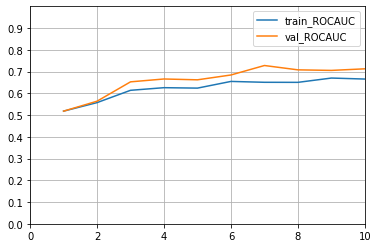

In [6]:
#Printing and saving learning curves (ROCAUC)
number_of_points = len(history['val_loss'])
x_arr = np.arange(number_of_points) + 1

fig, ax = plt.subplots()
ax.axis([0,number_of_points,0,1])
     
train_rocauc_arr = np.array(history['train_ROCAUC'])
val_rocauc_arr = np.array(history['val_ROCAUC'])
max_val_rocauc = np.round(np.max(val_rocauc_arr),4)
ax.plot(x_arr, train_rocauc_arr, label = 'train_ROCAUC')
ax.plot(x_arr, val_rocauc_arr, label = 'val_ROCAUC')
ax.set_yticks(np.arange(0., 1., 0.1), minor = False)
ax.grid(True)
ax.legend()
print("Max val_ROCAUC:", max_val_rocauc)
plt.savefig(os.path.join(IMAGES_DIR, 'learning_curves'), dpi = IMG_DPI)

Min loss: 0.6706


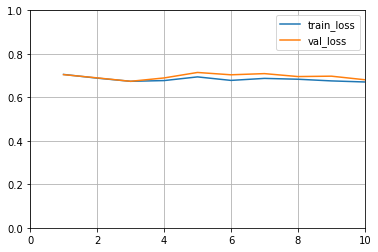

In [7]:
#Printing and saving learning curves (loss)
number_of_points = len(history['train_loss'])
x_arr = np.arange(number_of_points) + 1

fig, ax = plt.subplots()
ax.axis([0,number_of_points,0,1])
     
train_loss_arr = np.array(history['train_loss'])
val_loss_arr = np.array(history['val_loss'])
max_loss = np.round(np.max(train_loss_arr),4)
min_loss = np.round(np.min(train_loss_arr),4)
ax.plot(x_arr, train_loss_arr, label = 'train_loss')
ax.plot(x_arr, val_loss_arr, label = 'val_loss')
#ax.set_yticks(np.arange(0., 1.1* max_loss, 0.1), minor = False)
ax.grid(True)
ax.legend()
print("Min loss:", min_loss)
plt.savefig(os.path.join(IMAGES_DIR, 'loss_curves'), dpi = IMG_DPI)

In [8]:
#Defining test generator (for metrics computing)
test_datagen = ImageDataGenerator(
        samplewise_std_normalization = samplewise_std_normalization, 
        samplewise_center = samplewise_center,
        featurewise_std_normalization = featurewise_std_normalization,
        featurewise_center = featurewise_center,
        rescale = rescale
)

test_generator = test_datagen.flow_from_dataframe(
        dataframe = df_test,
        x_col="filename",
        y_col="output_classes",
        directory = TEST_IMAGES_DIR,
        target_size=(config_dict['image_size'], config_dict['image_size']),
        batch_size=BATCH_SIZE,
        class_mode='binary',
        shuffle = False 
    )
       
class_weights = get_class_weigts(test_generator)
print('Class_indices: ', test_generator.class_indices)
print('class_weights:', class_weights)


Found 238 validated image filenames belonging to 2 classes.
Class_indices:  {'non-retina': 0, 'retina': 1}
class_weights: {1: 1.0, 0: 2.6615384615384614}


In [9]:
model_filenames

['last_cv_prod_test.h5', 'best_cv_prod_test_.h5']

In [10]:
#Importing the model
model_filepath = os.path.join(MODEL_DIR, model_filenames[0])
model = load_model(model_filepath)

In [11]:
probs = model.predict_generator(test_generator)

In [13]:
#Choosing the threshold using train dataset

df_train_path = os.path.join(MODEL_DIR, "temp_dataframes", "_".join(["df", config_dict["model_name"], "train.csv"]))
df_train = remove_flips_from_df(pd.read_csv(df_train_path))

train_generator = test_datagen.flow_from_dataframe(
        dataframe = df_train,
        x_col="filename",
        y_col="output_classes",
        directory = TRAIN_IMAGES_DIR,
        target_size=(config_dict["image_size"], config_dict["image_size"]),
        batch_size=32,
        class_mode=config_dict["class_mode"],
        shuffle = False 
    )
train_probs = model.predict_generator(train_generator)
threshold = choose_roc_threshold(train_generator.labels, train_probs)

Found 703 validated image filenames belonging to 2 classes.


In [14]:
threshold

0.40707585

In [15]:
#Converting probabilities to labels using threshold 
threshold
choose_class_binary = lambda x: 0 if x < threshold else 1
choose_classes= lambda x: np.array([choose_class_binary(x[i]) for i in range(x.shape[0])])

labels= np.array(test_generator.labels)
preds = choose_classes(probs)

In [16]:
#Calculating different metrics
test_acc = np.sum(labels == preds) / test_generator.n
test_precision = np.sum((preds == 1)*(labels == 1)) / np.sum(preds == 1 )
test_recall = np.sum((preds == 1)*(labels == 1)) / np.sum(labels == 1)
test_f1 = 2 * test_precision * test_recall / (test_precision + test_recall)
#test_f1 = f1_score(labels, preds)

metrics_dict = {
    'test_acc': accuracy_score(labels, preds).astype(np.float64),
    'test_precision': precision_score(labels, preds).astype(np.float64),
    'test_recall': recall_score(labels, preds).astype(np.float64),
    'test_f1': f1_score(labels, preds).astype(np.float64),
    'threshold': threshold.astype(np.float64),
    'rocauc': roc_auc_score(labels, probs)
}

print(metrics_dict)

{'test_acc': 0.6974789915966386, 'test_precision': 0.8633093525179856, 'test_recall': 0.6936416184971098, 'test_f1': 0.7692307692307692, 'threshold': 0.4070758521556854, 'rocauc': 0.7364161849710983}


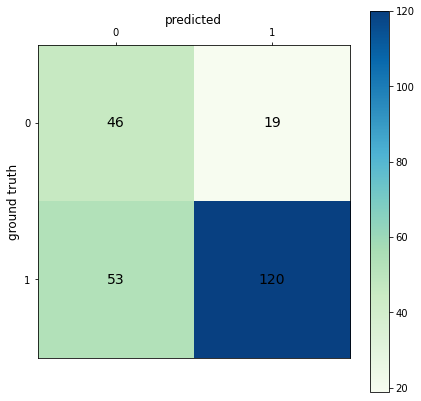

In [20]:
#Confusion matrix on test dataset
visualize_confusion_matrix(
    confusion_matrix(labels, preds), 
    img_path=os.path.join(IMAGES_DIR, 'confusion_matrix'),
    img_dpi=IMG_DPI
)


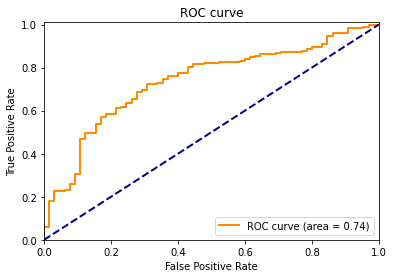

In [18]:
#ROC curve and ROCAUC on test dataset
fpr, tpr, _ = roc_curve(labels, probs)
roc_auc = roc_auc_score(labels, probs)
#plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.01])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.legend(loc="lower right")
#plt.show()
plt.savefig(os.path.join(IMAGES_DIR, 'ROC_curve'), dpi = IMG_DPI)